# Chapter 9: 워드 임베딩
* 희소 표현 (Sparse Representation)
  * 원-핫 인코딩을 통해서 나온 원-핫 벡터들은 표현하고자 하는 단어의 인덱스의 값만 1이고, 나머지 인덱스에는 전부 0으로 표현되는 벡터 표현 방법
  * 원-핫 벡터는 희소 벡터
* 밀집 표현 (Dense Representation)
  * 밀집 표현은 벡터의 차원을 단어 집합의 크기로 상정하지 않음
  * 사용자가 설정한 값으로 모든 단어의 벡터 표현의 차원을 맞춤
  * 이 과정에서 더 이상 0과 1만 가진 값이 아니라 실수값을 가지게 됨

## Word2Vec 실습 (영어)

In [2]:
import re
import urllib.request
import zipfile
from lxml import etree
from nltk.tokenize import word_tokenize, sent_tokenize

### 훈련 데이터 다운로드

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/09.%20Word%20Embedding/dataset/ted_en-20160408.xml", filename="ted_en-20160408.xml")

('ted_en-20160408.xml', <http.client.HTTPMessage at 0x1b2fc4c5580>)

### 훈련데이터 전처리

In [4]:
targetXML = open('ted_en-20160408.xml', 'r', encoding='UTF8')
target_text = etree.parse(targetXML)

# xml 파일로부터 <content>와 </content> 사이의 내용만 가져온다.
parse_text = '\n'.join(target_text.xpath('//content/text()'))

# 정규 표현식의 sub 모듈을 통해 content 중간에 등장하는 (Audio), (Laughter) 등의 배경음 부분을 제거.
# 해당 코드는 괄호로 구성된 내용을 제거.
content_text = re.sub(r'\([^)]*\)', '', parse_text)

# 입력 코퍼스에 대해서 NLTK를 이용하여 문장 토큰화를 수행.
sent_text = sent_tokenize(content_text)

# 각 문장에 대해서 구두점을 제거하고, 대문자를 소문자로 변환.
normalized_text = []
for string in sent_text:
     tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
     normalized_text.append(tokens)

# 각 문장에 대해서 NLTK를 이용하여 단어 토큰화를 수행.
result = [word_tokenize(sentence) for sentence in normalized_text]

In [5]:
print('총 샘플의 개수 : {}'.format(len(result)))

총 샘플의 개수 : 273424


### Word2Vec 훈련하기

In [8]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

# vector_size = 워드 벡터의 특징 값. 즉, 임베딩 된 벡터의 차원.
# window = 컨텍스트 윈도우 크기
# min_count = 단어 최소 빈도 수 제한 (빈도가 적은 단어들은 학습하지 않는다.)
# workers = 학습을 위한 프로세스 수
# sg = 0은 CBOW, 1은 Skip-gram.
model = Word2Vec(sentences=result, vector_size=100, window=5, min_count=5, workers=4, sg=0)

In [9]:
model_result = model.wv.most_similar("man")
print(model_result)

[('woman', 0.836270809173584), ('guy', 0.8032562732696533), ('boy', 0.7865258455276489), ('lady', 0.76373690366745), ('girl', 0.7602448463439941), ('soldier', 0.7313371300697327), ('gentleman', 0.7271599769592285), ('poet', 0.6975290179252625), ('kid', 0.695356011390686), ('rabbi', 0.6601399779319763)]


###  Word2Vec 모델 저장하고 로드하기

In [10]:
model.wv.save_word2vec_format('eng_w2v') # 모델 저장
loaded_model = KeyedVectors.load_word2vec_format("eng_w2v") # 모델 로드

model_result = loaded_model.most_similar("man")
print(model_result)

[('woman', 0.836270809173584), ('guy', 0.8032562732696533), ('boy', 0.7865258455276489), ('lady', 0.76373690366745), ('girl', 0.7602448463439941), ('soldier', 0.7313371300697327), ('gentleman', 0.7271599769592285), ('poet', 0.6975290179252625), ('kid', 0.695356011390686), ('rabbi', 0.6601399779319763)]


## Word2Vec 실습 (한국어)
* 네이버 영화 리뷰

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt
from tqdm import tqdm

### 데이터 다운로드

In [6]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x14efce69fd0>)

### 훈련데이터 전처리

In [7]:
train_data = pd.read_table('ratings.txt')
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

# 정규 표현식을 통한 한글 외 문자 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 형태소 분석기 OKT를 사용한 토큰화 작업 (다소 시간 소요)
okt = Okt()

tokenized_data = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data.append(stopwords_removed_sentence)

False


C:\Users\shy02\AppData\Local\Temp\ipykernel_30152\3466470468.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
100%|██████████| 199992/199992 [06:40<00:00, 498.75it/s]


리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 10.716703668146726


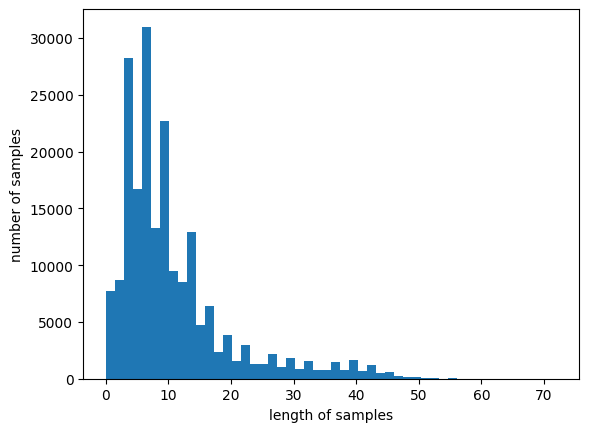

In [8]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(review) for review in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(review) for review in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### Word2Vec 학습하기

In [9]:
from gensim.models import Word2Vec

model = Word2Vec(sentences = tokenized_data, vector_size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

In [10]:
print(model.wv.most_similar("최민식"))

[('한석규', 0.8710899353027344), ('안성기', 0.8574127554893494), ('최민수', 0.8332411050796509), ('김수현', 0.8183349370956421), ('박중훈', 0.8179751038551331), ('유다인', 0.8120590448379517), ('윤제문', 0.8092328310012817), ('톰크루즈', 0.809205949306488), ('김명민', 0.8075396418571472), ('설경구', 0.8060240745544434)]


In [11]:
print(model.wv.most_similar("히어로"))

[('느와르', 0.8697344660758972), ('슬래셔', 0.8696305751800537), ('무협', 0.8662356734275818), ('호러', 0.8387969732284546), ('블록버스터', 0.8162915706634521), ('뱀파이어', 0.8033558130264282), ('물의', 0.8029681444168091), ('홍콩', 0.8028662204742432), ('무비', 0.7980051040649414), ('물', 0.7912806272506714)]


## 사전 훈련된 Word2Vec 임베딩

In [13]:
import gensim
import urllib.request

# 구글의 사전 훈련된 Word2Vec 모델을 로드. <- 이건 url이 없어짐
urllib.request.urlretrieve("https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz", filename="GoogleNews-vectors-negative300.bin.gz")
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

HTTPError: HTTP Error 404: Not Found

In [ ]:
print(word2vec_model.similarity('this', 'is'))
print(word2vec_model.similarity('post', 'book'))

# Chapter 13: 서브워드 토크나이저
* 기계에게 아무리 많은 단어를 학습시켜도 세상의 모든 단어를 알려줄 수는 없는 노릇
* 이와 같이 모르는 단어로 인해 문제를 푸는 것이 까다로워지는 상황을 OOV(Out-Of-Vocabulary) 문제라고 함
* 서브워드 분리(Subword segmenation) 작업은 하나의 단어는 더 작은 단위의 의미있는 여러 서브워드들(Ex) birthplace = birth + place)의 조합으로 구성된 경우가 많기 때문에, 하나의 단어를 여러 서브워드로 분리해서 단어를 인코딩 및 임베딩하겠다는 의도를 가진 전처리 작업

## BPE(Byte Pair Encoding)

In [31]:
import re, collections
from IPython.display import display, Markdown, Latex

num_merges = 10 # BPE을 몇 회 수행할 것인지를 정함

# BPE에 사용할 단어가 low, lower, newest, widest일 때, BPE의 입력으로 사용하는 실제 단어 집합은 아래와 같음
dictionary = {'l o w </w>' : 5,
         'l o w e r </w>' : 2,
         'n e w e s t </w>':6,
         'w i d e s t </w>':3
         }

# BPE의 코드
def get_stats(dictionary):
    # 유니그램의 pair들의 빈도수를 카운트
    pairs = collections.defaultdict(int)
    for word, freq in dictionary.items():
        symbols = word.split()
        for i in range(len(symbols)-1):
            pairs[symbols[i],symbols[i+1]] += freq
    print('현재 pair들의 빈도수 :', dict(pairs))
    return pairs

def merge_dictionary(pair, v_in):
    v_out = {}
    bigram = re.escape(' '.join(pair))
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word]
    return v_out

bpe_codes = {}
bpe_codes_reverse = {}

for i in range(num_merges):
    display(Markdown("### Iteration {}".format(i + 1)))
    pairs = get_stats(dictionary)
    best = max(pairs, key=pairs.get)
    dictionary = merge_dictionary(best, dictionary)

    bpe_codes[best] = i
    bpe_codes_reverse[best[0] + best[1]] = best

    print("new merge: {}".format(best))
    print("dictionary: {}".format(dictionary))

### Iteration 1

현재 pair들의 빈도수 : {('l', 'o'): 7, ('o', 'w'): 7, ('w', '</w>'): 5, ('w', 'e'): 8, ('e', 'r'): 2, ('r', '</w>'): 2, ('n', 'e'): 6, ('e', 'w'): 6, ('e', 's'): 9, ('s', 't'): 9, ('t', '</w>'): 9, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'e'): 3}
new merge: ('e', 's')
dictionary: {'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w es t </w>': 6, 'w i d es t </w>': 3}


### Iteration 2

현재 pair들의 빈도수 : {('l', 'o'): 7, ('o', 'w'): 7, ('w', '</w>'): 5, ('w', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('n', 'e'): 6, ('e', 'w'): 6, ('w', 'es'): 6, ('es', 't'): 9, ('t', '</w>'): 9, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'es'): 3}
new merge: ('es', 't')
dictionary: {'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w est </w>': 6, 'w i d est </w>': 3}


### Iteration 3

현재 pair들의 빈도수 : {('l', 'o'): 7, ('o', 'w'): 7, ('w', '</w>'): 5, ('w', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('n', 'e'): 6, ('e', 'w'): 6, ('w', 'est'): 6, ('est', '</w>'): 9, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'est'): 3}
new merge: ('est', '</w>')
dictionary: {'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w est</w>': 6, 'w i d est</w>': 3}


### Iteration 4

현재 pair들의 빈도수 : {('l', 'o'): 7, ('o', 'w'): 7, ('w', '</w>'): 5, ('w', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('n', 'e'): 6, ('e', 'w'): 6, ('w', 'est</w>'): 6, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'est</w>'): 3}
new merge: ('l', 'o')
dictionary: {'lo w </w>': 5, 'lo w e r </w>': 2, 'n e w est</w>': 6, 'w i d est</w>': 3}


### Iteration 5

현재 pair들의 빈도수 : {('lo', 'w'): 7, ('w', '</w>'): 5, ('w', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('n', 'e'): 6, ('e', 'w'): 6, ('w', 'est</w>'): 6, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'est</w>'): 3}
new merge: ('lo', 'w')
dictionary: {'low </w>': 5, 'low e r </w>': 2, 'n e w est</w>': 6, 'w i d est</w>': 3}


### Iteration 6

현재 pair들의 빈도수 : {('low', '</w>'): 5, ('low', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('n', 'e'): 6, ('e', 'w'): 6, ('w', 'est</w>'): 6, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'est</w>'): 3}
new merge: ('n', 'e')
dictionary: {'low </w>': 5, 'low e r </w>': 2, 'ne w est</w>': 6, 'w i d est</w>': 3}


### Iteration 7

현재 pair들의 빈도수 : {('low', '</w>'): 5, ('low', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('ne', 'w'): 6, ('w', 'est</w>'): 6, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'est</w>'): 3}
new merge: ('ne', 'w')
dictionary: {'low </w>': 5, 'low e r </w>': 2, 'new est</w>': 6, 'w i d est</w>': 3}


### Iteration 8

현재 pair들의 빈도수 : {('low', '</w>'): 5, ('low', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('new', 'est</w>'): 6, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'est</w>'): 3}
new merge: ('new', 'est</w>')
dictionary: {'low </w>': 5, 'low e r </w>': 2, 'newest</w>': 6, 'w i d est</w>': 3}


### Iteration 9

현재 pair들의 빈도수 : {('low', '</w>'): 5, ('low', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'est</w>'): 3}
new merge: ('low', '</w>')
dictionary: {'low</w>': 5, 'low e r </w>': 2, 'newest</w>': 6, 'w i d est</w>': 3}


### Iteration 10

현재 pair들의 빈도수 : {('low', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'est</w>'): 3}
new merge: ('w', 'i')
dictionary: {'low</w>': 5, 'low e r </w>': 2, 'newest</w>': 6, 'wi d est</w>': 3}


In [32]:
print(bpe_codes) # Merge 했던 기록 출력

{('e', 's'): 0, ('es', 't'): 1, ('est', '</w>'): 2, ('l', 'o'): 3, ('lo', 'w'): 4, ('n', 'e'): 5, ('ne', 'w'): 6, ('new', 'est</w>'): 7, ('low', '</w>'): 8, ('w', 'i'): 9}


## OOV에 대처하기

In [33]:
def get_pairs(word):
    """Return set of symbol pairs in a word.
    Word is represented as a tuple of symbols (symbols being variable-length strings).
    """
    pairs = set()
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char
    return pairs


def encode(orig):
    """Encode word based on list of BPE merge operations, which are applied consecutively"""

    word = tuple(orig) + ('</w>',)
    display(Markdown("__word split into characters:__ <tt>{}</tt>".format(word)))

    pairs = get_pairs(word)    

    if not pairs:
        return orig

    iteration = 0
    while True:
        iteration += 1
        display(Markdown("__Iteration {}:__".format(iteration)))

        print("bigrams in the word: {}".format(pairs))
        bigram = min(pairs, key = lambda pair: bpe_codes.get(pair, float('inf')))
        print("candidate for merging: {}".format(bigram))
        if bigram not in bpe_codes:
            display(Markdown("__Candidate not in BPE merges, algorithm stops.__"))
            break
        first, second = bigram
        new_word = []
        i = 0
        while i < len(word):
            try:
                j = word.index(first, i)
                new_word.extend(word[i:j])
                i = j
            except:
                new_word.extend(word[i:])
                break

            if word[i] == first and i < len(word)-1 and word[i+1] == second:
                new_word.append(first+second)
                i += 2
            else:
                new_word.append(word[i])
                i += 1
        new_word = tuple(new_word)
        word = new_word
        print("word after merging: {}".format(word))
        if len(word) == 1:
            break
        else:
            pairs = get_pairs(word)

    # 특별 토큰인 </w>는 출력하지 않는다.
    if word[-1] == '</w>':
        word = word[:-1]
    elif word[-1].endswith('</w>'):
        word = word[:-1] + (word[-1].replace('</w>',''),)

    return word

In [34]:
encode("loki")

__word split into characters:__ <tt>('l', 'o', 'k', 'i', '</w>')</tt>

__Iteration 1:__

bigrams in the word: {('k', 'i'), ('l', 'o'), ('i', '</w>'), ('o', 'k')}
candidate for merging: ('l', 'o')
word after merging: ('lo', 'k', 'i', '</w>')


__Iteration 2:__

bigrams in the word: {('k', 'i'), ('lo', 'k'), ('i', '</w>')}
candidate for merging: ('k', 'i')


__Candidate not in BPE merges, algorithm stops.__

('lo', 'k', 'i')

In [35]:
encode("lowest")

__word split into characters:__ <tt>('l', 'o', 'w', 'e', 's', 't', '</w>')</tt>

__Iteration 1:__

bigrams in the word: {('w', 'e'), ('s', 't'), ('e', 's'), ('t', '</w>'), ('o', 'w'), ('l', 'o')}
candidate for merging: ('e', 's')
word after merging: ('l', 'o', 'w', 'es', 't', '</w>')


__Iteration 2:__

bigrams in the word: {('es', 't'), ('t', '</w>'), ('o', 'w'), ('w', 'es'), ('l', 'o')}
candidate for merging: ('es', 't')
word after merging: ('l', 'o', 'w', 'est', '</w>')


__Iteration 3:__

bigrams in the word: {('w', 'est'), ('l', 'o'), ('est', '</w>'), ('o', 'w')}
candidate for merging: ('est', '</w>')
word after merging: ('l', 'o', 'w', 'est</w>')


__Iteration 4:__

bigrams in the word: {('l', 'o'), ('w', 'est</w>'), ('o', 'w')}
candidate for merging: ('l', 'o')
word after merging: ('lo', 'w', 'est</w>')


__Iteration 5:__

bigrams in the word: {('lo', 'w'), ('w', 'est</w>')}
candidate for merging: ('lo', 'w')
word after merging: ('low', 'est</w>')


__Iteration 6:__

bigrams in the word: {('low', 'est</w>')}
candidate for merging: ('low', 'est</w>')


__Candidate not in BPE merges, algorithm stops.__

('low', 'est')

In [36]:
encode("lowing")

__word split into characters:__ <tt>('l', 'o', 'w', 'i', 'n', 'g', '</w>')</tt>

__Iteration 1:__

bigrams in the word: {('w', 'i'), ('n', 'g'), ('o', 'w'), ('i', 'n'), ('l', 'o'), ('g', '</w>')}
candidate for merging: ('l', 'o')
word after merging: ('lo', 'w', 'i', 'n', 'g', '</w>')


__Iteration 2:__

bigrams in the word: {('w', 'i'), ('n', 'g'), ('lo', 'w'), ('i', 'n'), ('g', '</w>')}
candidate for merging: ('lo', 'w')
word after merging: ('low', 'i', 'n', 'g', '</w>')


__Iteration 3:__

bigrams in the word: {('n', 'g'), ('i', 'n'), ('low', 'i'), ('g', '</w>')}
candidate for merging: ('n', 'g')


__Candidate not in BPE merges, algorithm stops.__

('low', 'i', 'n', 'g')

## 센텐스피스 (SentensePiece)
* 내부 단어 분리를 위한 유용한 패키지

In [37]:
!pip install sentencepiece

                                              0.0/977.6 kB ? eta -:--:--
     -----------                            286.7/977.6 kB 8.9 MB/s eta 0:00:01
     -------------------                    491.5/977.6 kB 6.2 MB/s eta 0:00:01
     -------------------------              665.6/977.6 kB 6.0 MB/s eta 0:00:01
     ----------------------------------     890.9/977.6 kB 5.1 MB/s eta 0:00:01
     -------------------------------------- 977.6/977.6 kB 5.2 MB/s eta 0:00:00


In [38]:
import sentencepiece as spm
import pandas as pd
import urllib.request
import csv

urllib.request.urlretrieve("https://raw.githubusercontent.com/LawrenceDuan/IMDb-Review-Analysis/master/IMDb_Reviews.csv", filename="IMDb_Reviews.csv")

train_df = pd.read_csv('IMDb_Reviews.csv')
train_df['review']

0        My family and I normally do not watch local mo...
1        Believe it or not, this was at one time the wo...
2        After some internet surfing, I found the "Home...
3        One of the most unheralded great works of anim...
4        It was the Sixties, and anyone with long hair ...
                               ...                        
49995    the people who came up with this are SICK AND ...
49996    The script is so so laughable... this in turn,...
49997    "So there's this bride, you see, and she gets ...
49998    Your mind will not be satisfied by this nobud...
49999    The chaser's war on everything is a weekly sho...
Name: review, Length: 50000, dtype: object

In [39]:
# 센텐스피스의 입력으로 사용하기 위해서 데이터프레임을 txt 파일로 저장
with open('imdb_review.txt', 'w', encoding='utf8') as f:
    f.write('\n'.join(train_df['review']))

In [40]:
# 센텐스피스로 단어 집합과 각 단어에 고유한 정수를 부여 (아래는 인자별 의미)
# input : 학습시킬 파일
# model_prefix : 만들어질 모델 이름
# vocab_size : 단어 집합의 크기
# model_type : 사용할 모델 (unigram(default), bpe, char, word)
# max_sentence_length: 문장의 최대 길이
# pad_id, pad_piece: pad token id, 값
# unk_id, unk_piece: unknown token id, 값
# bos_id, bos_piece: begin of sentence token id, 값
# eos_id, eos_piece: end of sequence token id, 값
# user_defined_symbols: 사용자 정의 토큰
spm.SentencePieceTrainer.Train('--input=imdb_review.txt --model_prefix=imdb --vocab_size=5000 --model_type=bpe --max_sentence_length=9999')

In [41]:
vocab_list = pd.read_csv('imdb.vocab', sep='\t', header=None, quoting=csv.QUOTE_NONE)
vocab_list.sample(10)

sp = spm.SentencePieceProcessor()
vocab_file = "imdb.model"
sp.load(vocab_file)

lines = [
  "I didn't at all think of it this way.",
  "I have waited a long time for someone to film"
]
for line in lines:
  print(line)
  print(sp.encode_as_pieces(line))
  print(sp.encode_as_ids(line))
  print()

I didn't at all think of it this way.
['▁I', '▁didn', "'", 't', '▁at', '▁all', '▁think', '▁of', '▁it', '▁this', '▁way', '.']
[41, 624, 4950, 4926, 139, 170, 378, 30, 58, 73, 413, 4945]

I have waited a long time for someone to film
['▁I', '▁have', '▁wa', 'ited', '▁a', '▁long', '▁time', '▁for', '▁someone', '▁to', '▁film']
[41, 142, 1364, 1121, 4, 668, 285, 93, 1079, 33, 91]



## 네이버 영화 리뷰 토큰화하기

In [44]:
import pandas as pd
import sentencepiece as spm
import urllib.request
import csv

urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

naver_df = pd.read_table('ratings.txt')

naver_df = naver_df.dropna(how = 'any') # Null 값이 존재하는 행 제거

with open('naver_review.txt', 'w', encoding='utf8') as f:
    f.write('\n'.join(naver_df['document']))
    
spm.SentencePieceTrainer.Train('--input=naver_review.txt --model_prefix=naver --vocab_size=5000 --model_type=bpe --max_sentence_length=9999')

In [45]:
# vocab 생성이 완료되면 naver.model, naver.vocab 파일 두개가 생성
# .vocab 에서 학습된 subwords를 확인할 수 있음
vocab_list = pd.read_csv('naver.vocab', sep='\t', header=None, quoting=csv.QUOTE_NONE)
vocab_list[:10]

,0,1
0,<unk>,0
1,<s>,0
2,</s>,0
3,..,0
4,영화,-1
5,▁영화,-2
6,▁이,-3
7,▁아,-4
8,...,-5
9,ᄏᄏ,-6


In [46]:
sp = spm.SentencePieceProcessor()
vocab_file = "naver.model"
sp.load(vocab_file)

lines = [
  "뭐 이딴 것도 영화냐.",
  "진짜 최고의 영화입니다 ㅋㅋ",
]
for line in lines:
  print(line)
  print(sp.encode_as_pieces(line))
  print(sp.encode_as_ids(line))
  print()

뭐 이딴 것도 영화냐.
['▁뭐', '▁이딴', '▁것도', '▁영화냐', '.']
[136, 970, 1299, 2593, 3276]

진짜 최고의 영화입니다 ㅋㅋ
['▁진짜', '▁최고의', '▁영화입니다', '▁ᄏᄏ']
[54, 204, 825, 121]



## 서브워드텍스트인코더 (SubwordTextEncoder)
* SubwordTextEncoder는 텐서플로우를 통해 사용할 수 있는 서브워드 토크나이저
* BPE와 유사한 알고리즘인 Wordpiece Model을 채택
* 패키지를 통해 쉽게 단어들을 서브워드들로 분리할 수 있음

### IMDB 리뷰 토큰화하기

In [14]:
import pandas as pd
import urllib.request
import tensorflow_datasets as tfds

urllib.request.urlretrieve("https://raw.githubusercontent.com/LawrenceDuan/IMDb-Review-Analysis/master/IMDb_Reviews.csv", filename="IMDb_Reviews.csv")

train_df = pd.read_csv('IMDb_Reviews.csv')

train_df['review']

0        My family and I normally do not watch local mo...
1        Believe it or not, this was at one time the wo...
2        After some internet surfing, I found the "Home...
3        One of the most unheralded great works of anim...
4        It was the Sixties, and anyone with long hair ...
                               ...                        
49995    the people who came up with this are SICK AND ...
49996    The script is so so laughable... this in turn,...
49997    "So there's this bride, you see, and she gets ...
49998    Your mind will not be satisfied by this nobud...
49999    The chaser's war on everything is a weekly sho...
Name: review, Length: 50000, dtype: object

In [15]:
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    train_df['review'], target_vocab_size=2**13)

AttributeError: module 'tensorflow_datasets.core.features' has no attribute 'text'

## 허깅페이스 토크나이저(Huggingface Tokenizer)
* 자주 등장하는 서브워드들을 하나의 토큰으로 취급하는 다양한 서브워드 토크나이저를 제공

In [62]:
!pip install tokenizers --upgrade

In [16]:
import pandas as pd
import urllib.request
from tokenizers import BertWordPieceTokenizer

urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

naver_df = pd.read_table('ratings.txt')
naver_df = naver_df.dropna(how='any')
with open('naver_review.txt', 'w', encoding='utf8') as f:
    f.write('\n'.join(naver_df['document']))
    
tokenizer = BertWordPieceTokenizer(lowercase=False, trip_accents=False)

TypeError: __init__() got an unexpected keyword argument 'trip_accents'

In [ ]:
data_file = 'naver_review.txt'
vocab_size = 30000
limit_alphabet = 6000
min_frequency = 5

tokenizer.train(files=data_file,
                vocab_size=vocab_size,
                limit_alphabet=limit_alphabet,
                min_frequency=min_frequency)

In [ ]:
# vocab 저장
tokenizer.save_model('./')

# vocab 로드
df = pd.read_fwf('vocab.txt', header=None)

In [ ]:
encoded = tokenizer.encode('아 배고픈데 짜장면먹고싶다')
print('토큰화 결과 :',encoded.tokens)
print('정수 인코딩 :',encoded.ids)
print('디코딩 :',tokenizer.decode(encoded.ids))

In [ ]:
encoded = tokenizer.encode('커피 한잔의 여유를 즐기다')
print('토큰화 결과 :',encoded.tokens)
print('정수 인코딩 :',encoded.ids)
print('디코딩 :',tokenizer.decode(encoded.ids))